Since my results for multi-classification were not as good as I expected, I decided to try lazy classification. Lazy classification is a method that evaluates the performance of multiple baseline models on a dataset. It is a good way to get a sense of the performance of the models on the dataset.

In [92]:
from insignificant.SupervisedOverr import LazyClassifier
from methods.helper import *
import os
import sys
from methods.feature_selection import *

# Supress all warnings
import warnings
warnings.filterwarnings("ignore")
# Suppress LightGBM logs
from contextlib import contextmanager
os.environ['LIGHTGBM_VERBOSE'] = '0'

Loading the data

In [190]:
lipidomics, metabolomics, proteomics = load_data()
X_train, X_test, Y_train, Y_test = concatenate_data(
    lipidomics, metabolomics, proteomics
)

In [191]:
@contextmanager
def suppress_output():
    # Context manager to suppress stdout and stderr
    # I wanted to silence the output of the LazyClassifier
    with open(os.devnull, 'w') as devnull:
        old_stdout = sys.stdout
        old_stderr = sys.stderr
        sys.stdout = devnull
        sys.stderr = devnull
        try:
            yield
        finally:
            sys.stdout = old_stdout
            sys.stderr = old_stderr

def lazy_classifier(x_train, x_test, y_train, y_test):
    """
    Run the lazy classifier on the dataset
    :param x_train: Training data
    :param x_test: Testing data
    :param y_train: Training labels
    :param y_test: Testing labels
    """
    with suppress_output():
        # Run the lazy classifier
        clf = LazyClassifier(verbose=0, ignore_warnings=True, custom_metric=None)
        return clf.fit(x_train, x_test, y_train, y_test)

In [177]:
def get_best_model(models_):
    """
    Get the best model from the lazy classifier based on the F1 score
    :param models_: Models from the lazy classifier
    """
    max_f1_ = models_['F1 Score'].max()
    index = models_['F1 Score'].idxmax()
    return models_[models_['F1 Score'] == max_f1_], index

First, I will run the lazy classifier on the dataset without any feature selection.

In [178]:
models, predictions = lazy_classifier(X_train, X_test, Y_train, Y_test)
print(get_best_model(models)[0])

               Accuracy  Balanced Accuracy ROC AUC  F1 Score  Time Taken
Model                                                                   
XGBClassifier      0.58               0.47    None      0.53        0.27


Now I will filter the dataset using various feature selection methods and run the lazy classifier on the filtered dataset.

### 1. Mutual Information Filtering

In [184]:
# Set the style of the plots
sns.set(style="whitegrid")

def plot_results(result_df, title):
    plt.figure(figsize=(7, 4))
    sns.lineplot(
        x='Keep Ratio', y='F1 Score', data=result_df, 
        color='deepskyblue', marker='o')
    # Add names of the models
    for i in range(result_df.shape[0]):
        plt.text(
            result_df['Keep Ratio'].iloc[i], result_df['F1 Score'].iloc[i],
            result_df['Model'].iloc[i], horizontalalignment='left',
            size='small', color='black'
        )
    plt.title(title)
    plt.show()

In [180]:
def test_FS_lazy_classification(FS_method):
    
    result_df = pd.DataFrame(columns=['Keep Ratio', 'F1 Score', 'Model'])
    keep_ratio_range = np.arange(0.1, 1.1, 0.1)

    for keep_ratio in keep_ratio_range:
        filtered_features = FS_method(
            X_=X_train, Y_=Y_train, keep_ratio=keep_ratio
        )
        X_train_filtered = X_train[filtered_features]
        X_test_filtered = X_test[filtered_features]
        
        models_, _ = lazy_classifier(X_train_filtered, X_test_filtered, Y_train, Y_test)
        best_model_, index_ = get_best_model(models_)
        # Get the index of the best model
        print(f"Keep ratio: {keep_ratio:.1f}, "
              f"F1 score: {best_model_['F1 Score'].values[0]:.3f}, "
              f"Model: {index_}")
        result_df = result_df.append({
            'Keep Ratio': keep_ratio,
            'F1 Score': best_model_['F1 Score'].values[0],
            'Model': index_
        }, ignore_index=True)
    
    return result_df

In [181]:
MIFS_results = test_FS_lazy_classification(mutual_information_filtering)

Keep ratio: 0.1, F1 score: 0.532, Model: RandomForestClassifier
Keep ratio: 0.2, F1 score: 0.580, Model: SGDClassifier
Keep ratio: 0.3, F1 score: 0.518, Model: NuSVC
Keep ratio: 0.4, F1 score: 0.518, Model: NuSVC
Keep ratio: 0.5, F1 score: 0.518, Model: NuSVC
Keep ratio: 0.6, F1 score: 0.518, Model: NuSVC
Keep ratio: 0.7, F1 score: 0.518, Model: NuSVC
Keep ratio: 0.8, F1 score: 0.516, Model: RandomForestClassifier
Keep ratio: 0.9, F1 score: 0.518, Model: NuSVC
Keep ratio: 1.0, F1 score: 0.533, Model: XGBClassifier


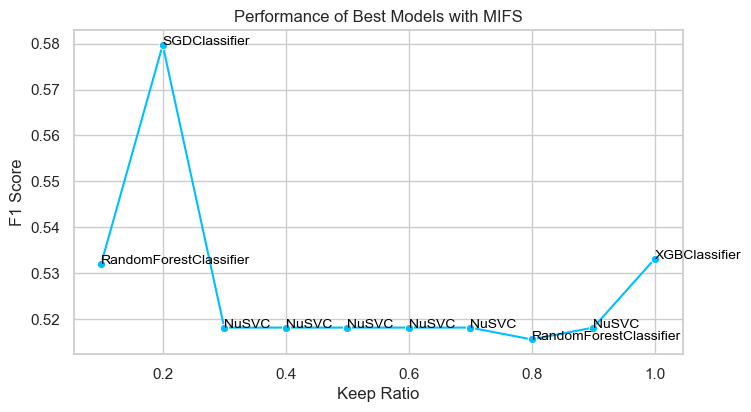

In [185]:
plot_results(MIFS_results, "Performance of Best Models with MIFS")

### 2. Recursive Feature Elimination

In [186]:
RFE_results = test_FS_lazy_classification(recursive_feature_elimination)

Keep ratio: 0.1, F1 score: 0.574, Model: ExtraTreesClassifier
Keep ratio: 0.2, F1 score: 0.516, Model: ExtraTreesClassifier
Keep ratio: 0.3, F1 score: 0.565, Model: AdaBoostClassifier
Keep ratio: 0.4, F1 score: 0.532, Model: XGBClassifier
Keep ratio: 0.5, F1 score: 0.520, Model: LinearDiscriminantAnalysis
Keep ratio: 0.6, F1 score: 0.518, Model: ExtraTreesClassifier
Keep ratio: 0.7, F1 score: 0.504, Model: NuSVC
Keep ratio: 0.8, F1 score: 0.518, Model: NuSVC
Keep ratio: 0.9, F1 score: 0.524, Model: RandomForestClassifier
Keep ratio: 1.0, F1 score: 0.533, Model: XGBClassifier


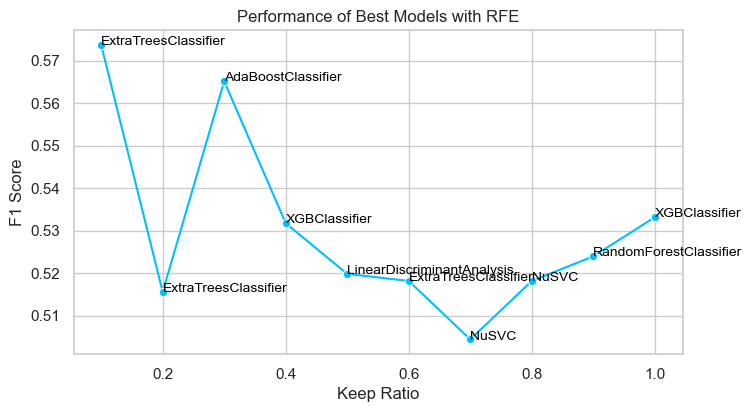

In [187]:
plot_results(RFE_results, "Performance of Best Models with RFE")

### 3. ANOVA Filtering

Keep ratio: 0.1, F1 score: 0.518, Model: SVC
Keep ratio: 0.2, F1 score: 0.528, Model: LGBMClassifier
Keep ratio: 0.3, F1 score: 0.500, Model: QuadraticDiscriminantAnalysis
Keep ratio: 0.4, F1 score: 0.568, Model: ExtraTreeClassifier
Keep ratio: 0.5, F1 score: 0.519, Model: LGBMClassifier
Keep ratio: 0.6, F1 score: 0.541, Model: LGBMClassifier
Keep ratio: 0.7, F1 score: 0.519, Model: LGBMClassifier
Keep ratio: 0.8, F1 score: 0.570, Model: LGBMClassifier
Keep ratio: 0.9, F1 score: 0.523, Model: XGBClassifier
Keep ratio: 1.0, F1 score: 0.533, Model: XGBClassifier


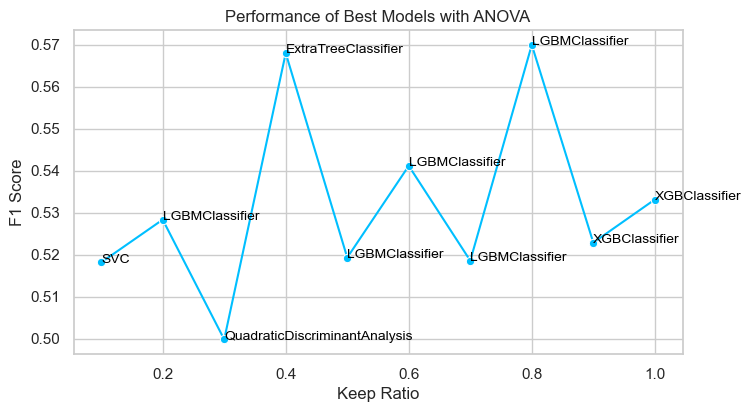

In [188]:
ANOVA_results = test_FS_lazy_classification(ANOVA_correlation_filtering)
plot_results(ANOVA_results, "Performance of Best Models with ANOVA")

### 4. Boruta Feature Selection

In [189]:
boruta_selected_features = boruta_filtering(X_train, Y_train)
X_train_boruta = X_train[boruta_selected_features]
X_test_boruta = X_test[boruta_selected_features]

models, _ = lazy_classifier(X_train_boruta, X_test_boruta, Y_train, Y_test)
print(get_best_model(models)[0])

                      Accuracy  Balanced Accuracy ROC AUC  F1 Score  \
Model                                                                 
ExtraTreesClassifier      0.45               0.42    None      0.45   

                      Time Taken  
Model                             
ExtraTreesClassifier        0.13  
